In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
# Load MNIST Fashion dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

x_train, x_test = utils.preprocess(x_train), utils.preprocess(x_test)

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
# Add random noise to images
x_train_noisy, x_test_noisy = utils.add_noise(x_train, noise_factor=0.2), utils.add_noise(x_test, noise_factor=0.2)

x_train_noisy.shape, x_test_noisy.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

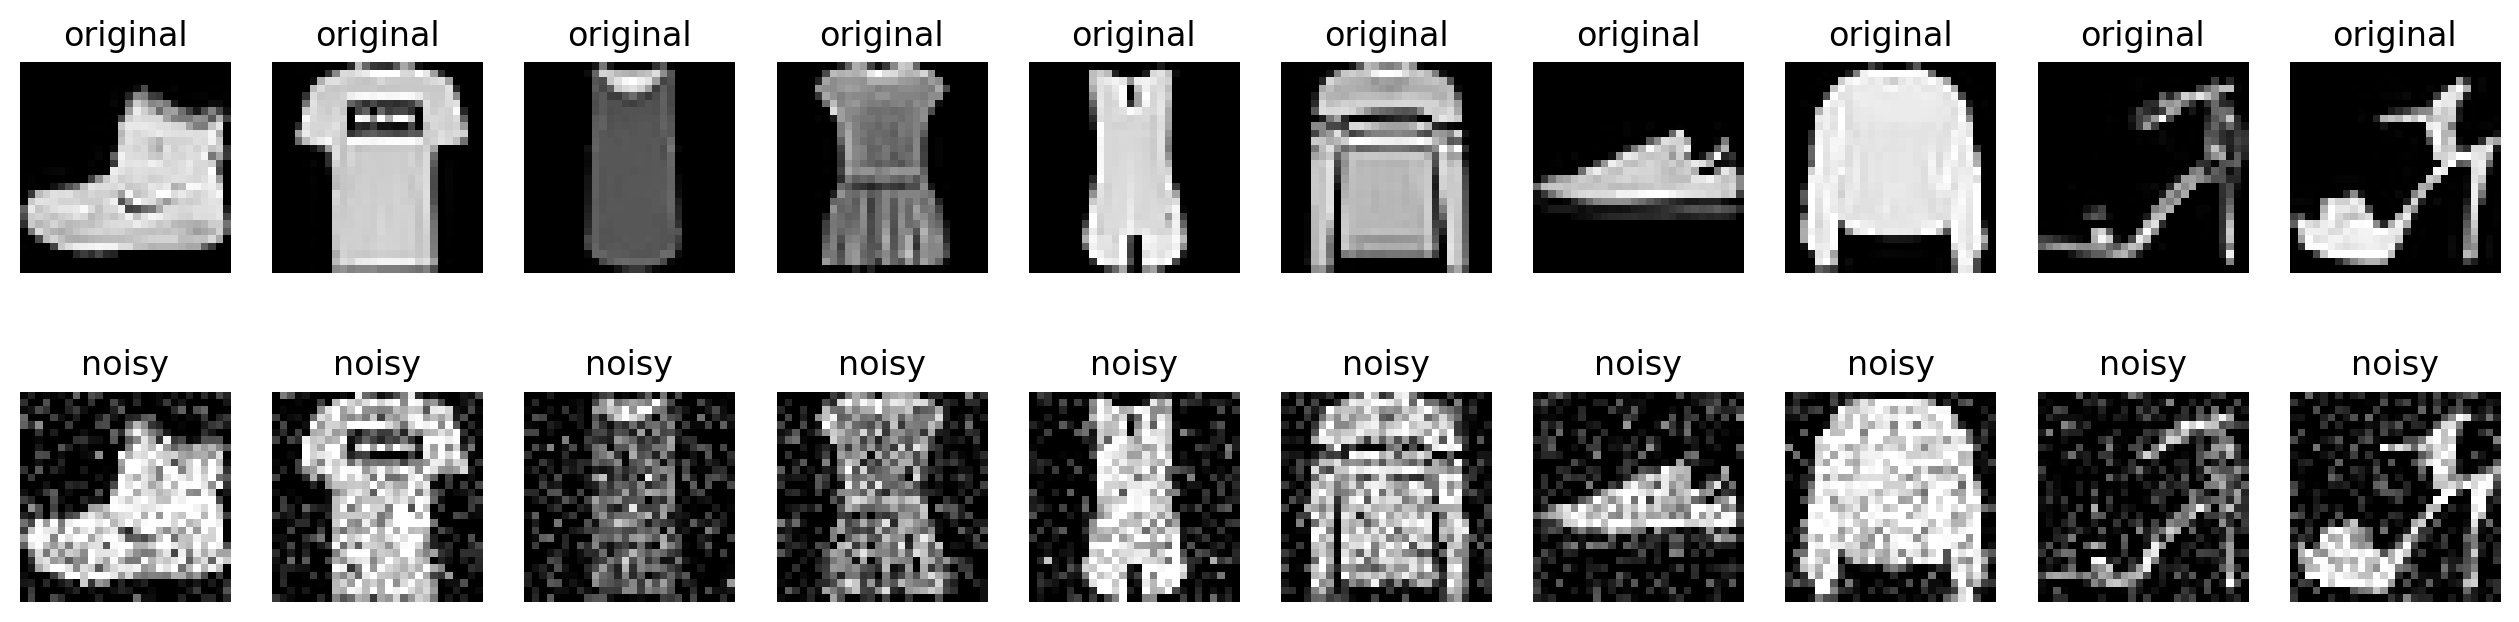

In [4]:
# Plot samples of noisy images and original images
n = 10

plt.figure(figsize=(16, 4), dpi=200)

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(x_train_noisy[i]), cmap='gray')
    plt.title('noisy')
    plt.axis('off')

In [5]:
# Denoiser model definition
class Denoiser(keras.models.Model):
    def __init__(self, input_shape):
        super(Denoiser, self).__init__()
        
        self.image_shape = input_shape
        
        # Encoder model
        self.encoder = keras.Sequential([
            keras.layers.Input(shape=self.image_shape),
            keras.layers.Conv2D(16, (3, 3), strides=2, padding='same', activation='relu'),
            keras.layers.Conv2D(8, (3, 3), strides=2, padding='same', activation='relu')
        ])
        
        # Decoder model
        self.decoder = keras.Sequential([
            keras.layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu'),
            keras.layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu'),
            keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
# Constants definition
INPUT_SHAPE = x_train_noisy.numpy().shape[1:]
EPOCHS = 10

In [7]:
# Autoencoder initialization
autoencoder = Denoiser(input_shape=INPUT_SHAPE)

# Compile model
autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

# Train model
history = autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
).history

Epoch 1/10
1875/1875 [==============================] - 13s 5ms/step - loss: 0.0178 - val_loss: 0.0109
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.

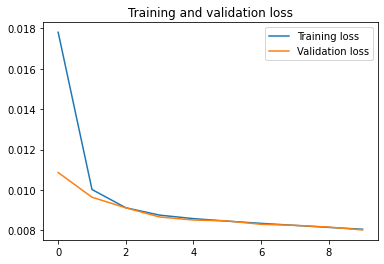

In [8]:
# Plot loss curve
utils.plot_loss(history)

In [10]:
# Summary of encoder
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Summary of decoder
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Generate some images from test set
encoded_images = autoencoder.encoder(x_test_noisy).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

decoded_images.shape

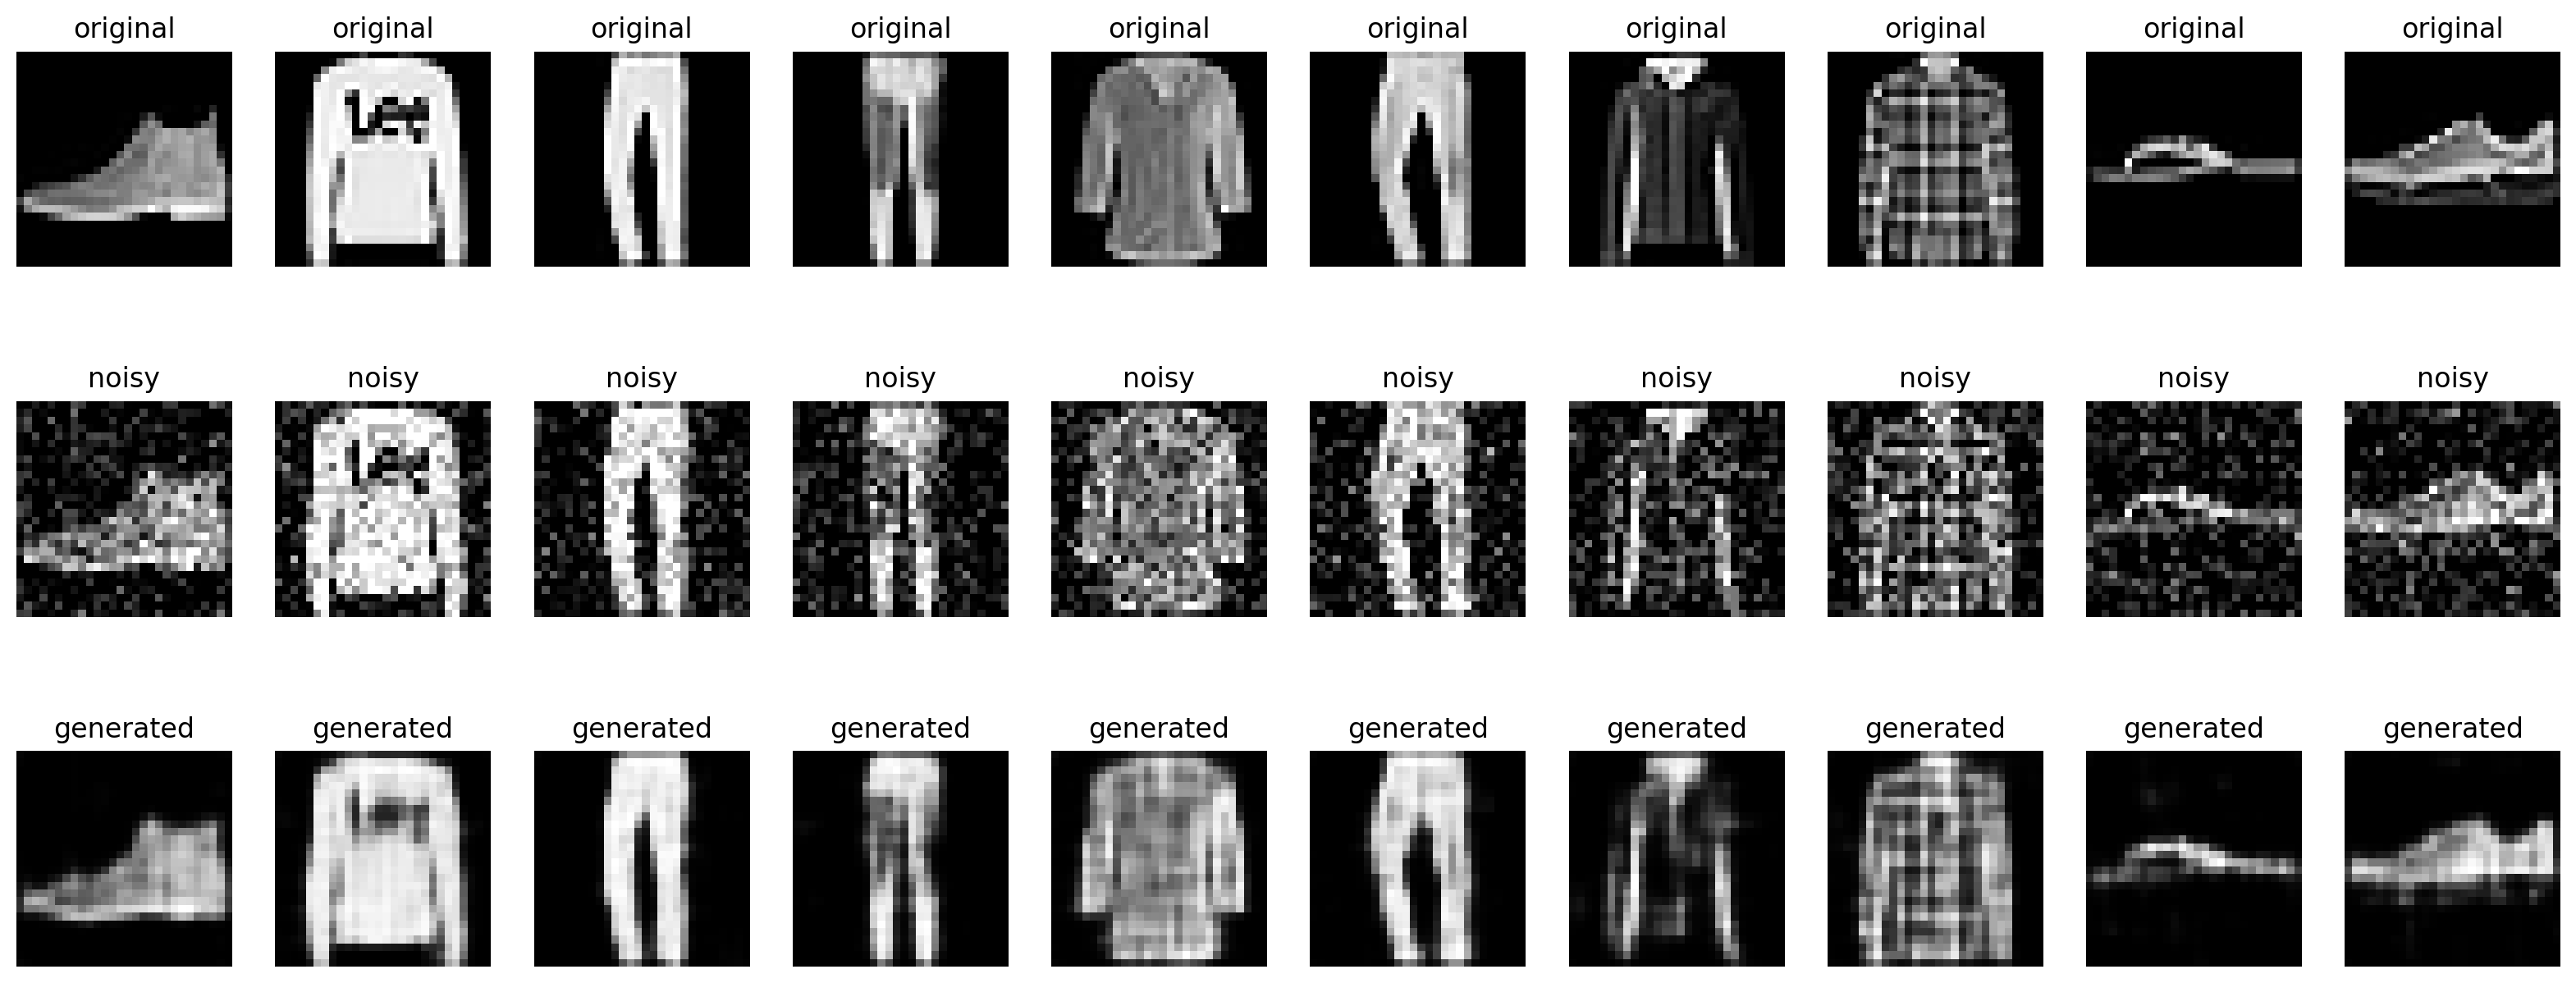

In [15]:
# Plot the results
n = 10

plt.figure(figsize=(20, 8), dpi=200)

for i in range(n):
    # Plot original images in row 1
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    # Plot noisy images in row 2
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i], cmap='gray')
    plt.title('noisy')
    plt.axis('off')
    
    # Plot generated images in row 3
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_images[i], cmap='gray')
    plt.title('generated')
    plt.axis('off')